### Packages loading

In [17]:
import sys
sys.path.insert(0, '..')
import matplotlib.pyplot as plt
from qtm.evolution import environment, mutate, selection, crossover
import qtm.constant
import qtm.ansatz
import qtm.qcompilation
import qtm.state
import qtm.evolution
import qiskit
import numpy as np
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Quantum architecture search for quantum state preparation problem

This is state preparation circuit which is generated by classical method (amplitude encoding)

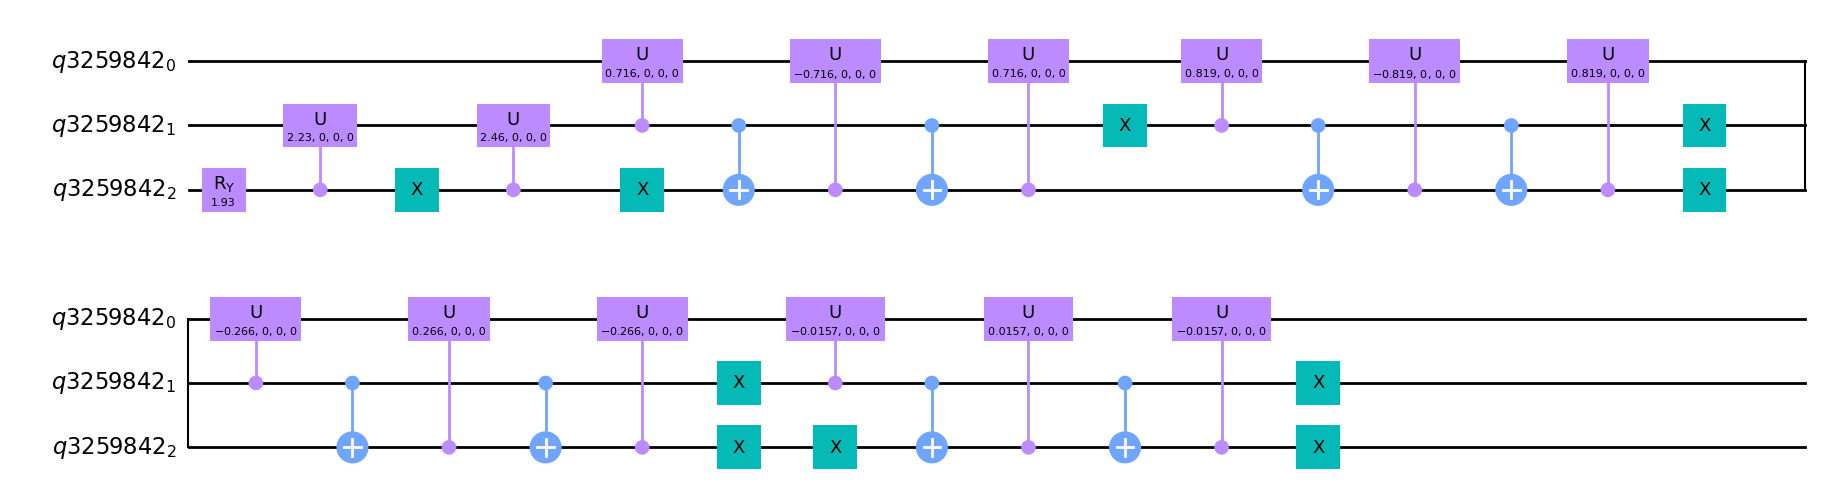

In [59]:
psi = 2*np.random.rand(2**3)-1
psi = psi / np.linalg.norm(psi)
encoder = qtm.encoding.Encoding(psi, 'amplitude_encoding')
qc = encoder.qcircuit
qc.draw('mpl')


Now, we defind the problem which is need to solve

In [60]:
qc_haar = qtm.state.create_specific_state(2,
    [ 0.73042448, -0.30956267, -0.45658101,  0.40272176])

qc_haar = qtm.state.create_haar_state(3)
def compilation_fitness(qc: qiskit.QuantumCircuit, num_steps=5):
    compiler = qtm.qcompilation.QuantumCompilation(
        u=qc,
        vdagger=qc_haar.inverse(),
        optimizer='adam',
        loss_func='loss_fubini_study'
    )
    compiler.fit(num_steps=num_steps, verbose=0)
    return np.average(compiler.loss_values)


def compilation_threshold(fitness_value):
    if fitness_value < 0.1:
        return True
    return False


Main algorithm, includes: init population, selection, crossover, mutate.

In [189]:
params = {'depth': 8,
          'num_circuit': 16,  # Must mod 8 = 0
          'num_generation': 10,
          'num_qubits': 3,
          'threshold': compilation_threshold,
          'prob_mutate': 0.1}

env = environment.EEnvironment(
    params,
    fitness_func=compilation_fitness,
    selection_func=selection.elitist_selection,
    crossover_func=crossover.onepoint_crossover,
    mutate_func=mutate.bitflip_mutate,
    pool=qtm.constant.operations
)

env.evol()

Initialize population ...
Start evol progress ...
Evol at generation 0
Fitness 0.6108495396205795, Strengh 4.70845980831618
0.625
Fitness 0.7133734099989864, Strengh 1.8312142532521865
0.25
Fitness 0.7494485864833976, Strengh 1.4911109271605247
0.125
Fitness 0.7664067548661921, Strengh 1.3834872632329016
0.125
Fitness 0.7729405451924658, Strengh 1.3486261021954316
0.125
Fitness 0.778503735686788, Strengh 1.3214530341490323
0.125
Fitness 0.7850447160133347, Strengh 1.2922004882617808
0.125
Fitness 0.7949260088218325, Strengh 1.2529785682620649
0.125


Evol at generation 1
Fitness 0.7333263093770968, Strengh 2.899082483981751
0.375
Fitness 0.7554033528302672, Strengh 2.217001497016603
0.25
Fitness 0.7719266948131873, Strengh 1.8722742531009504
0.25
Fitness 0.7760277395425803, Strengh 1.8030716858911235
0.25
Fitness 0.7829861904362547, Strengh 1.6979801945321555
0.25
Fitness 0.7859710295995865, Strengh 1.6572265994552446
0.25
Fitness 0.7955067486985996, Strengh 1.5423050473645623
0.25
Fitness 0.8380119328199352, Strengh 1.2302353386823563
0.125


Evol at generation 2
Fitness 0.5470762647778079, Strengh 4.964996217282004
0.625
Fitness 0.6348111530612075, Strengh 2.3838684266234518
0.25
Fitness 0.7517727538208954, Strengh 1.3401412158975137
0.125
Fitness 0.7599772694439793, Strengh 1.3082542916330273
0.125
Fitness 0.7690956526710173, Strengh 1.2763104058896775
0.125
Fitness 0.777229130851633, Strengh 1.2506208840591413
0.125
Fitness 0.7807567018749917, Strengh 1.24023519566188
0.125
Fitness 0.7878864343112778, Strengh 1.2205396744493142
0.125


Evol at generation 3
Fitness 0.6904482890643451, Strengh 2.4396546708528772
0.25
Fitness 0.7030664145381114, Strengh 2.135576244969106
0.25
Fitness 0.7124287038589795, Strengh 1.9522742688592873
0.25
Fitness 0.7155825027575131, Strengh 1.8974443404500374
0.25
Fitness 0.7167600311293006, Strengh 1.8777919640721188
0.25
Fitness 0.7231543696033249, Strengh 1.7783487044073778
0.25
Fitness 0.7666555853391529, Strengh 1.3435064842776583
0.125
Fitness 0.7683057953417796, Strengh 1.3330113289161984
0.125


Evol at generation 4
Fitness 0.7063673500115908, Strengh 2.6699592208811103
0.375
Fitness 0.7156701613142326, Strengh 2.3619325090526075
0.25
Fitness 0.7167448592273745, Strengh 2.330227447205858
0.25
Fitness 0.7290775781281368, Strengh 2.0151611070025544
0.25
Fitness 0.761305456776461, Strengh 1.500920510367957
0.25
Fitness 0.7707564140313942, Strengh 1.4072005764366589
0.125
Fitness 0.7880132521859524, Strengh 1.2789628959435186
0.125
Fitness 0.7887316457426597, Strengh 1.2746049112557347
0.125


Evol at generation 5
Fitness 0.6950002850384487, Strengh 2.377778580314365
0.25
Fitness 0.6991264531664514, Strengh 2.2327243339068987
0.25
Fitness 0.7006167961599866, Strengh 2.184173903996335
0.25
Fitness 0.7138351878356496, Strengh 1.829164757757153
0.25
Fitness 0.7300088451874945, Strengh 1.5361210571181882
0.25
Fitness 0.7339066100784676, Strengh 1.4826405283949007
0.125
Fitness 0.7345447802350121, Strengh 1.4744073720431525
0.125
Fitness 0.7491701328838687, Strengh 1.3198177902364825
0.125


Evol at generation 6
Fitness 0.6646687158868927, Strengh 3.2399811762841164
0.375
Fitness 0.6937018549952751, Strengh 2.005620886378071
0.25
Fitness 0.7005856696985624, Strengh 1.8317021537963216
0.25
Fitness 0.7043814191878341, Strengh 1.7490238600742982
0.25
Fitness 0.7134503277976847, Strengh 1.583246699102349
0.25
Fitness 0.7149689198250584, Strengh 1.5593194464677143
0.25
Fitness 0.7271141908037562, Strengh 1.4000943963580346
0.125
Fitness 0.7370342515256346, Strengh 1.3043144022719142
0.125


Evol at generation 7
Fitness 0.6637700455454623, Strengh 3.1869613951923856
0.375
Fitness 0.6937438780308255, Strengh 1.9160314187526488
0.25
Fitness 0.6997685783230783, Strengh 1.7690362194474103
0.25
Fitness 0.7058025462759638, Strengh 1.6454555893150107
0.25
Fitness 0.7160229407754615, Strengh 1.4797340948897515
0.125
Fitness 0.7162153781347491, Strengh 1.4770613162859583
0.125
Fitness 0.7170833563351151, Strengh 1.4651897474215971
0.125
Fitness 0.7171249861286548, Strengh 1.4646278492637195
0.125


Evol at generation 8
Fitness 0.6612373155458424, Strengh 3.0095968043601427
0.375
Fitness 0.6933577443198983, Strengh 1.7919002660379901
0.25
Fitness 0.6936047875069487, Strengh 1.7862486092107441
0.25
Fitness 0.7007818655413759, Strengh 1.6385443089626204
0.25
Fitness 0.7077293344483278, Strengh 1.5220514037091855
0.25
Fitness 0.7143372124326046, Strengh 1.4310338657559316
0.125
Fitness 0.7156015649304835, Strengh 1.4155196176251859
0.125
Fitness 0.7165733742312052, Strengh 1.4039756379295483
0.125


Evol at generation 9
Fitness 0.6644778212443686, Strengh 3.087421883821112
0.375
Fitness 0.6905525295572653, Strengh 1.7744210725515261
0.25
Fitness 0.6938401129353261, Strengh 1.683410354491326
0.25
Fitness 0.6941645744814844, Strengh 1.6750298174094087
0.25
Fitness 0.6943467323841441, Strengh 1.6703699747892475
0.25
Fitness 0.7017721035153233, Strengh 1.5054543197706272
0.25
Fitness 0.7052042934292294, Strengh 1.443606679569445
0.125
Fitness 0.7146757818085107, Strengh 1.3094375983907622
0.125


Step: 100%|██████████| 10/10 [15:29<00:00, 92.93s/it]

End evol progress, best score ever: 0.6596823913356882


In [ ]:
env.draw('./test')

In [191]:
env.set_num_generation(30)
env.evol()

Continute evol progress at generation 10 ...
Evol at generation 10
Fitness 0.6596823913356882, Strengh 2.4927852528832415
0.25
Fitness 0.6898258022434443, Strengh 1.6580743887087586
0.25
Fitness 0.6926619908604856, Strengh 1.6092634584452359
0.25
Fitness 0.6926900505240344, Strengh 1.608799096652484
0.25
Fitness 0.6927492980763525, Strengh 1.6078197660780695
0.25
Fitness 0.6931336633136806, Strengh 1.601504561954501
0.25
Fitness 0.6950571288093643, Strengh 1.5708738004373317
0.25
Fitness 0.6964911269482272, Strengh 1.5490570876868524
0.25


Evol at generation 11
Fitness 0.6902500883616632, Strengh 1.679776994058717
0.25
Fitness 0.691151568818984, Strengh 1.6669218937460015
0.25
Fitness 0.6915629685837599, Strengh 1.6611364020542108
0.25
Fitness 0.6916711106629252, Strengh 1.659623954257384
0.25
Fitness 0.693083640225737, Strengh 1.640183516852308
0.25
Fitness 0.6931353902459745, Strengh 1.6394822732954002
0.25
Fitness 0.693674445614911, Strengh 1.6322232687798017
0.25
Fitness 0.6939396918091674, Strengh 1.6286817281488901
0.25


Evol at generation 12
Fitness 0.690613410527864, Strengh 3.19270674591767
0.375
Fitness 0.6906891111555507, Strengh 3.059507366725349
0.375
Fitness 0.6918194845459894, Strengh 1.8078893772402922
0.25
Fitness 0.6923322239305699, Strengh 1.5284488276189132
0.25
Fitness 0.6926776061632574, Strengh 1.3970316480361722
0.125
Fitness 0.6928693457241221, Strengh 1.3387564656387896
0.125
Fitness 0.6928951723781844, Strengh 1.3315903982514312
0.125
Fitness 0.6931347195753623, Strengh 1.2719416837212019
0.125


Evol at generation 13
Fitness 0.6919876013880588, Strengh 1.749229622830484
0.25
Fitness 0.692157262510418, Strengh 1.7467106739085732
0.25
Fitness 0.6926616111133935, Strengh 1.7392725352159566
0.25
Fitness 0.6928242791757994, Strengh 1.7368893429725196
0.25
Fitness 0.6930535458729559, Strengh 1.7335434766366862
0.25
Fitness 0.6933832438480874, Strengh 1.7287585532601337
0.25
Fitness 0.6941596431047385, Strengh 1.717613562041015
0.25
Fitness 0.6945371377278646, Strengh 1.7122564777555631
0.25


Evol at generation 14
Fitness 0.6914388641608908, Strengh 1.5883223873816879
0.25
Fitness 0.6918330924365824, Strengh 1.5842995839974268
0.25
Fitness 0.6921983212221797, Strengh 1.5805972489835303
0.25
Fitness 0.6923797262189023, Strengh 1.5787670701526233
0.25
Fitness 0.6931382367935239, Strengh 1.571176809471873
0.25
Fitness 0.6932406247261508, Strengh 1.5701598886178483
0.25
Fitness 0.6932845077212809, Strengh 1.5697245955053285
0.25
Fitness 0.6933919921365865, Strengh 1.5686598176135707
0.25


Evol at generation 15
Fitness 0.6896962070997625, Strengh 1.6683497112315653
0.25
Fitness 0.6922547097111169, Strengh 1.6041250776315537
0.25
Fitness 0.6928637467304657, Strengh 1.5897693745903456
0.25
Fitness 0.6931875302650783, Strengh 1.5822768297835648
0.25
Fitness 0.6933876756875959, Strengh 1.5776930274897505
0.25
Fitness 0.6937862010165922, Strengh 1.5686730374055937
0.25
Fitness 0.6938935067349835, Strengh 1.56626850031771
0.25
Fitness 0.6939448066535004, Strengh 1.565122551980026
0.25


Evol at generation 16
Fitness 0.6921020358875454, Strengh 1.695791345994175
0.25
Fitness 0.692767437783908, Strengh 1.6306364666624737
0.25
Fitness 0.6930959525836483, Strengh 1.6007554800502946
0.25
Fitness 0.6931001125248775, Strengh 1.6003863236410347
0.25
Fitness 0.6934200355578429, Strengh 1.5726652092322377
0.25
Fitness 0.6935150521394844, Strengh 1.5646813287350985
0.25
Fitness 0.693733630734521, Strengh 1.5467350006271858
0.25
Fitness 0.693842499260628, Strengh 1.5380103165182648
0.25


Evol at generation 17
Fitness 0.6904645193271618, Strengh 1.6027539646755553
0.25
Fitness 0.6906902754891251, Strengh 1.5999310651669827
0.25
Fitness 0.6911865510842455, Strengh 1.5937719256181309
0.25
Fitness 0.6923248019286368, Strengh 1.5798831839979124
0.25
Fitness 0.6929954988051809, Strengh 1.5718520550881478
0.25
Fitness 0.693256731198289, Strengh 1.5687541622336343
0.25
Fitness 0.6937142275632902, Strengh 1.5633691980191657
0.25
Fitness 0.6937884450692728, Strengh 1.56250043950372
0.25


Evol at generation 18
Fitness 0.689436217350371, Strengh 1.6153424728877095
0.25
Fitness 0.6915948322007186, Strengh 1.5887026727877627
0.25
Fitness 0.6918221907806279, Strengh 1.5859648242101994
0.25
Fitness 0.692862787674968, Strengh 1.5735955750331336
0.25
Fitness 0.6929691342739853, Strengh 1.5723462658804634
0.25
Fitness 0.6929794884789754, Strengh 1.5722247750720197
0.25
Fitness 0.6931669778483995, Strengh 1.570029329109198
0.25
Fitness 0.6937276257952113, Strengh 1.563514430580982
0.25


Evol at generation 19
Fitness 0.6913223101970334, Strengh 1.7479687366417282
0.25
Fitness 0.6915233855325703, Strengh 1.7455847317445676
0.25
Fitness 0.6931617494484194, Strengh 1.7264408857760003
0.25
Fitness 0.6933556269662406, Strengh 1.7242082523243192
0.25
Fitness 0.6935687297284655, Strengh 1.7217621422229037
0.25
Fitness 0.6946908966441055, Strengh 1.709016946989241
0.25
Fitness 0.694841713588193, Strengh 1.7073212633253556
0.25
Fitness 0.695256915930336, Strengh 1.702673930357862
0.25


Evol at generation 20
Fitness 0.691469361998198, Strengh 1.6009949904485832
0.25
Fitness 0.6916160961932345, Strengh 1.5989709284009272
0.25
Fitness 0.6920146831826165, Strengh 1.5935071325365138
0.25
Fitness 0.6920827330169107, Strengh 1.5925793048848798
0.25
Fitness 0.6930011250705117, Strengh 1.580198420170648
0.25
Fitness 0.6933027231517122, Strengh 1.5761892519848446
0.25
Fitness 0.6934578550583101, Strengh 1.574137872451104
0.25
Fitness 0.6943777320573972, Strengh 1.5621230972307096
0.25


Evol at generation 21
Fitness 0.6901713426961239, Strengh 2.885390089691726
0.375
Fitness 0.6908319536267038, Strengh 2.3752868253561434
0.25
Fitness 0.6913101774026824, Strengh 2.094489694159275
0.25
Fitness 0.6918124653737541, Strengh 1.8610715837140979
0.25
Fitness 0.6923852991655138, Strengh 1.6549919019331147
0.25
Fitness 0.6935996274881563, Strengh 1.3667662186516725
0.125
Fitness 0.6942735569731584, Strengh 1.2658392959665372
0.125
Fitness 0.6942752201447601, Strengh 1.2656282391203324
0.125


Evol at generation 22
Fitness 0.6911373014710016, Strengh 3.1805754618508395
0.375
Fitness 0.6917439024099261, Strengh 2.5475818841498157
0.375
Fitness 0.6929709518417829, Strengh 1.773426708919584
0.25
Fitness 0.693232408724446, Strengh 1.667164323257623
0.25
Fitness 0.6936761193813588, Strengh 1.5191634106691017
0.25
Fitness 0.694226955005674, Strengh 1.380256545208739
0.125
Fitness 0.6943742897048759, Strengh 1.349870052024593
0.125
Fitness 0.6944215557228021, Strengh 1.3406459262439607
0.125


Evol at generation 23
Fitness 0.6886231899767123, Strengh 1.6999503889691154
0.25
Fitness 0.692162317184511, Strengh 1.59953829941847
0.25
Fitness 0.6925861570045599, Strengh 1.5885226035073314
0.25
Fitness 0.6929277338024159, Strengh 1.5797924041995914
0.25
Fitness 0.6933076691254231, Strengh 1.570233868704972
0.25
Fitness 0.6936401338539193, Strengh 1.5619989826406169
0.25
Fitness 0.6936650798371775, Strengh 1.5613859083761743
0.25
Fitness 0.6937459225119459, Strengh 1.5594037048576173
0.25


Evol at generation 24
Fitness 0.6905544823267891, Strengh 1.6729104204337504
0.25
Fitness 0.6914283769985634, Strengh 1.6482968781541754
0.25
Fitness 0.6919545061977701, Strengh 1.6339145842440668
0.25
Fitness 0.6920323502099696, Strengh 1.6318139052962624
0.25
Fitness 0.6923984032219278, Strengh 1.622028642698508
0.25
Fitness 0.692597306573787, Strengh 1.6167752920619458
0.25
Fitness 0.6930872674108178, Strengh 1.6040231293731213
0.25
Fitness 0.6935172699859081, Strengh 1.5930489136776016
0.25


Evol at generation 25
Fitness 0.6917343742837286, Strengh 1.786178182556563
0.25
Fitness 0.6920515008363607, Strengh 1.744521663119777
0.25
Fitness 0.692934347620113, Strengh 1.6398172156940958
0.25
Fitness 0.693304395981221, Strengh 1.6004358865348642
0.25
Fitness 0.6934018159799646, Strengh 1.5904775732734806
0.25
Fitness 0.6934106193110052, Strengh 1.5895858709653077
0.25
Fitness 0.6934811293600455, Strengh 1.5824922195240747
0.25
Fitness 0.6936554959807004, Strengh 1.5653144313121468
0.25


Evol at generation 26
Fitness 0.6906831909278466, Strengh 1.6304748761272234
0.25
Fitness 0.6911381846258952, Strengh 1.6232733831333503
0.25
Fitness 0.6920989022941036, Strengh 1.6083365251463961
0.25
Fitness 0.6921743696681519, Strengh 1.6071784652540961
0.25
Fitness 0.6930913610311344, Strengh 1.5932819697742824
0.25
Fitness 0.6934671445835496, Strengh 1.587679470337998
0.25
Fitness 0.6936742911562501, Strengh 1.5846138057977108
0.25
Fitness 0.6937580530651521, Strengh 1.5833787173450857
0.25


Evol at generation 27
Fitness 0.6908333026354917, Strengh 2.974051386616362
0.375
Fitness 0.6921375227252622, Strengh 1.8611534966425904
0.25
Fitness 0.6922412894153414, Strengh 1.8061503535695023
0.25
Fitness 0.6922798821420739, Strengh 1.7866022606561602
0.25
Fitness 0.6922833777675595, Strengh 1.7848552330508156
0.25
Fitness 0.6924386081651632, Strengh 1.711064010805134
0.25
Fitness 0.6928922033688689, Strengh 1.5328531224775932
0.25
Fitness 0.6939034127660698, Strengh 1.28007279982047
0.125


Evol at generation 28
Fitness 0.6912322537453, Strengh 1.6351531954613736
0.25
Fitness 0.6916350553702049, Strengh 1.6273630759898114
0.25
Fitness 0.6921632007183205, Strengh 1.6172934132980368
0.25
Fitness 0.6932576243190687, Strengh 1.5969385653738521
0.25
Fitness 0.6932959904896056, Strengh 1.5962373130719867
0.25
Fitness 0.6935475307623417, Strengh 1.5916600515256694
0.25
Fitness 0.6936634914172612, Strengh 1.5895617731871758
0.25
Fitness 0.693839062739493, Strengh 1.586399009068484
0.25


Evol at generation 29
Fitness 0.6906737903650152, Strengh 2.4407003056879715
0.25
Fitness 0.6910224798883065, Strengh 2.186792575885525
0.25
Fitness 0.6911560771699566, Strengh 2.1018305023461368
0.25
Fitness 0.6917901285603529, Strengh 1.774477855728914
0.25
Fitness 0.691973243738024, Strengh 1.699506540057885
0.25
Fitness 0.6924844848542788, Strengh 1.5264307634455287
0.25
Fitness 0.6925536825897305, Strengh 1.5065612104074293
0.25
Fitness 0.6928177470837117, Strengh 1.4373888379357262
0.125


Step:  67%|██████▋   | 20/30 [25:50<12:55, 77.52s/it]

End evol progress, best score ever: 0.6909914389248064


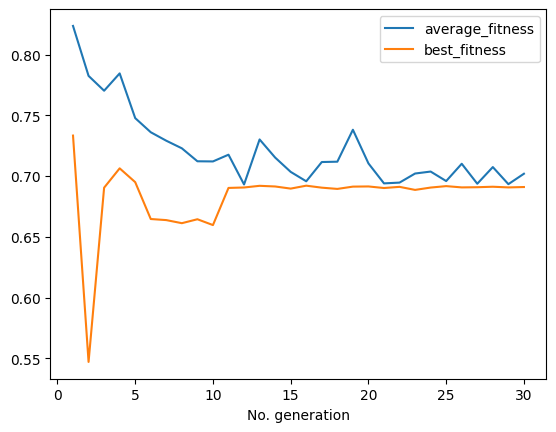

In [192]:
env.plot(metrics = ['average_fitness', 'best_fitness'])

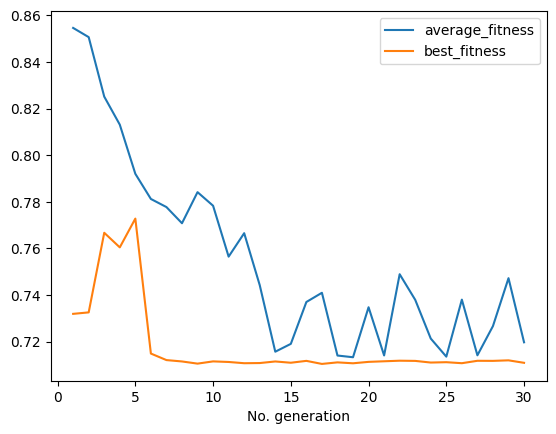

In [164]:
env.plot(metrics = ['average_fitness', 'best_fitness'])

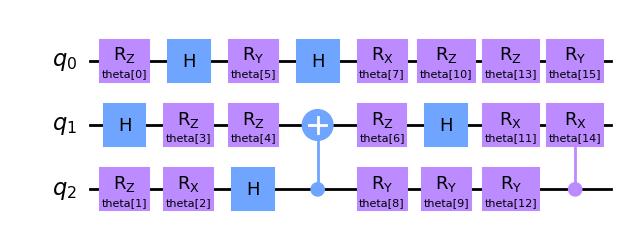

In [193]:
env.best_candidate.qc.draw('mpl')

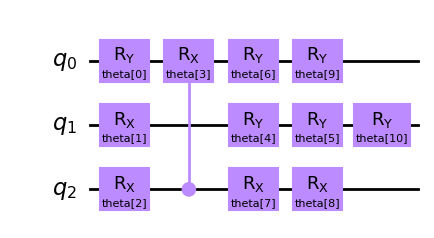

In [184]:
env2.populations[-1][7].qc.draw('mpl')

In [183]:
env2 = environment.EEnvironment('./ga_3qubits_compilation_fitness_2023-10-09.envobj')

Test best candidate again

In [194]:
qc = env.best_candidate.qc
compiler = qtm.qcompilation.QuantumCompilation(
    u=qc,
    vdagger=qc_haar.inverse(),
    optimizer='adam',
    loss_func='loss_fubini_study'
)
compiler.fit(num_steps=200, verbose=1)



Step:   0%|          | 0/200 [00:00<?, ?it/s]

Step: 100%|██████████| 200/200 [02:55<00:00,  1.14it/s]


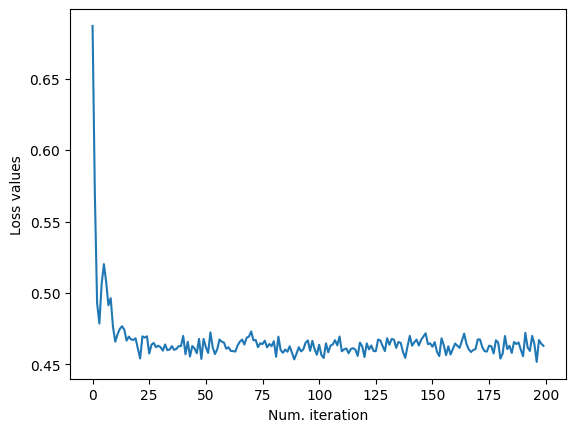

In [195]:
compiler.plot()

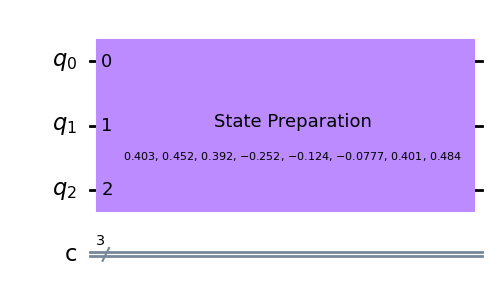

In [177]:
qc_haar.draw('mpl')


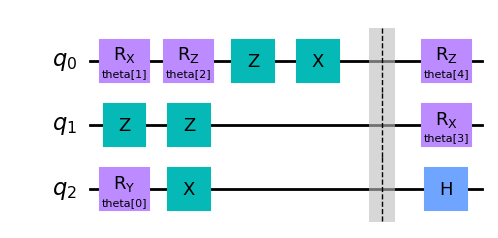

In [32]:
qc.draw('mpl')


In [188]:
qtm.ansatz.Wchain_ZXZlayer_ansatz(3, 2).depth()


12

In [186]:
compiler2 = qtm.qcompilation.QuantumCompilation(
    # u = random_circuit.random_circuit(3, 10),
    # vdagger = qtm.state.create_w_state(qc.num_qubits).inverse(),
    u=qtm.ansatz.Wchain_ZXZlayer_ansatz(3, 2),
    vdagger=qc_haar.inverse(),
    optimizer='adam',
    loss_func='loss_fubini_study'
)
compiler2.fit(num_steps=200, verbose=1)


Step: 100%|██████████| 200/200 [05:37<00:00,  1.69s/it]


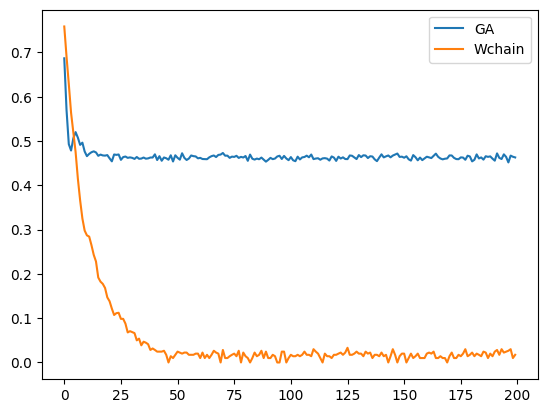

In [196]:
plt.plot(compiler.loss_values, label='GA')
plt.plot(compiler2.loss_values, label='Wchain')
plt.legend()